# Binary Classification with a Bank Churn Dataset

**Your Goal:** For this Episode of the Series, your task is to predict whether a customer continues with their account or closes it (e.g., churns). Good luck!

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Importing libraries

In [1]:
%pip install lightgbm
%pip install catboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from catboost.utils import get_roc_curve
from sklearn.model_selection import RandomizedSearchCV
import graphviz

## Importing data

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

In [4]:
sample_sub = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')

In [5]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [7]:
train_df = train_df.drop(['id', 'CustomerId', 'Surname'], axis=1)
test_df = test_df.drop(['id', 'CustomerId', 'Surname'],axis=1)

In [8]:
print(train_df['Geography'].unique())
print(train_df['Gender'].unique())

['France' 'Spain' 'Germany']
['Male' 'Female']


In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the 'Geography' column
train_df['Geography'] = label_encoder.fit_transform(train_df['Geography'])
test_df['Geography'] = label_encoder.transform(test_df['Geography'])

# Fit and transform the 'Gender' column
train_df['Gender'] = label_encoder.fit_transform(train_df['Gender'])
test_df['Gender'] = label_encoder.transform(test_df['Gender'])


train_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


## Exploratory data analysis

In [10]:
mean_df = train_df.groupby('Exited').mean().reset_index()
mean_df

,Exited,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,657.590710,0.625979,0.602046,36.560480,5.048796,51255.807752,1.615273,0.758894,0.552228,112084.293725
1,1,652.220469,0.732625,0.424272,43.958478,4.914378,71209.978085,1.327854,0.735546,0.294866,114402.496656


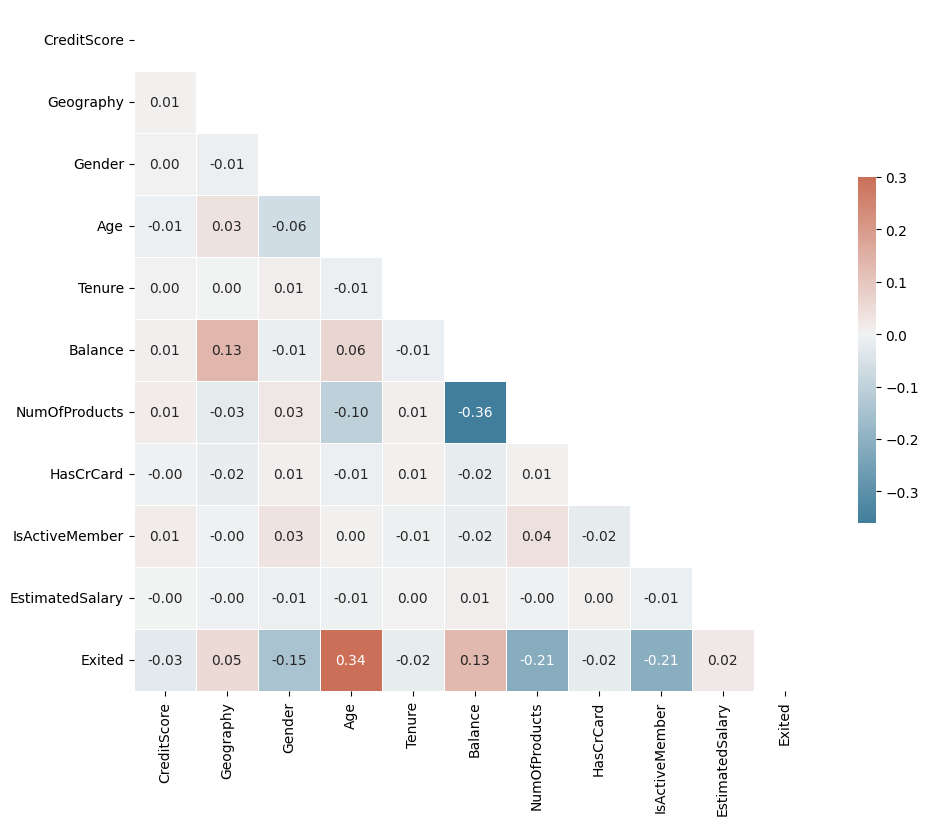

In [11]:
# add an anotations to each square 
# Compute the correlation matrix
corr = train_df.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask, correct aspect ratio and add annotations 
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.show()

Text(0.5, 1.0, 'Relationship between Balance and NumOfProducts')

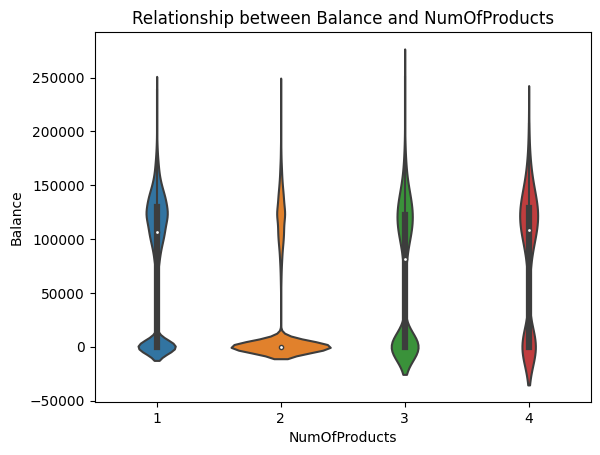

In [12]:
sns.violinplot(data=train_df, x="NumOfProducts", y='Balance')
plt.title('Relationship between Balance and NumOfProducts')

Text(0.5, 1.0, 'Relationship between Balance and Geography')

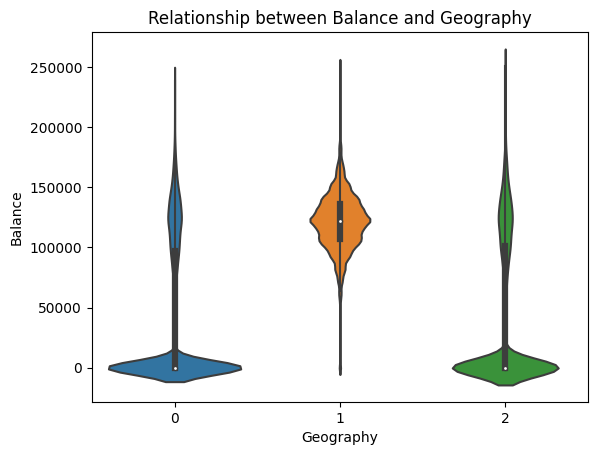

In [13]:

sns.violinplot(data=train_df, x='Geography', y='Balance')
plt.title('Relationship between Balance and Geography')

Text(0.5, 1.0, 'Relationship between Balance and Exited')

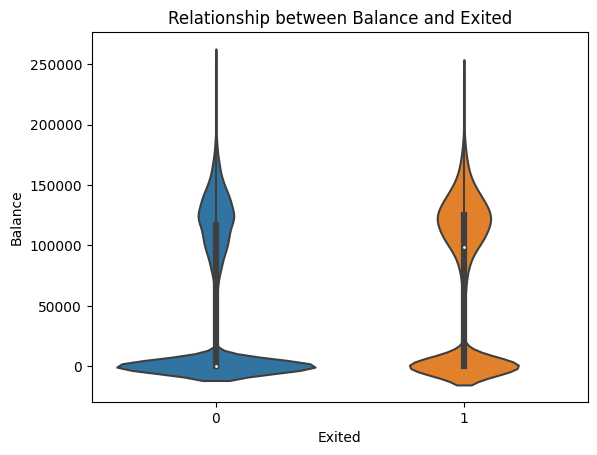

In [14]:
sns.violinplot(data=train_df, x='Exited', y='Balance')
plt.title('Relationship between Balance and Exited')

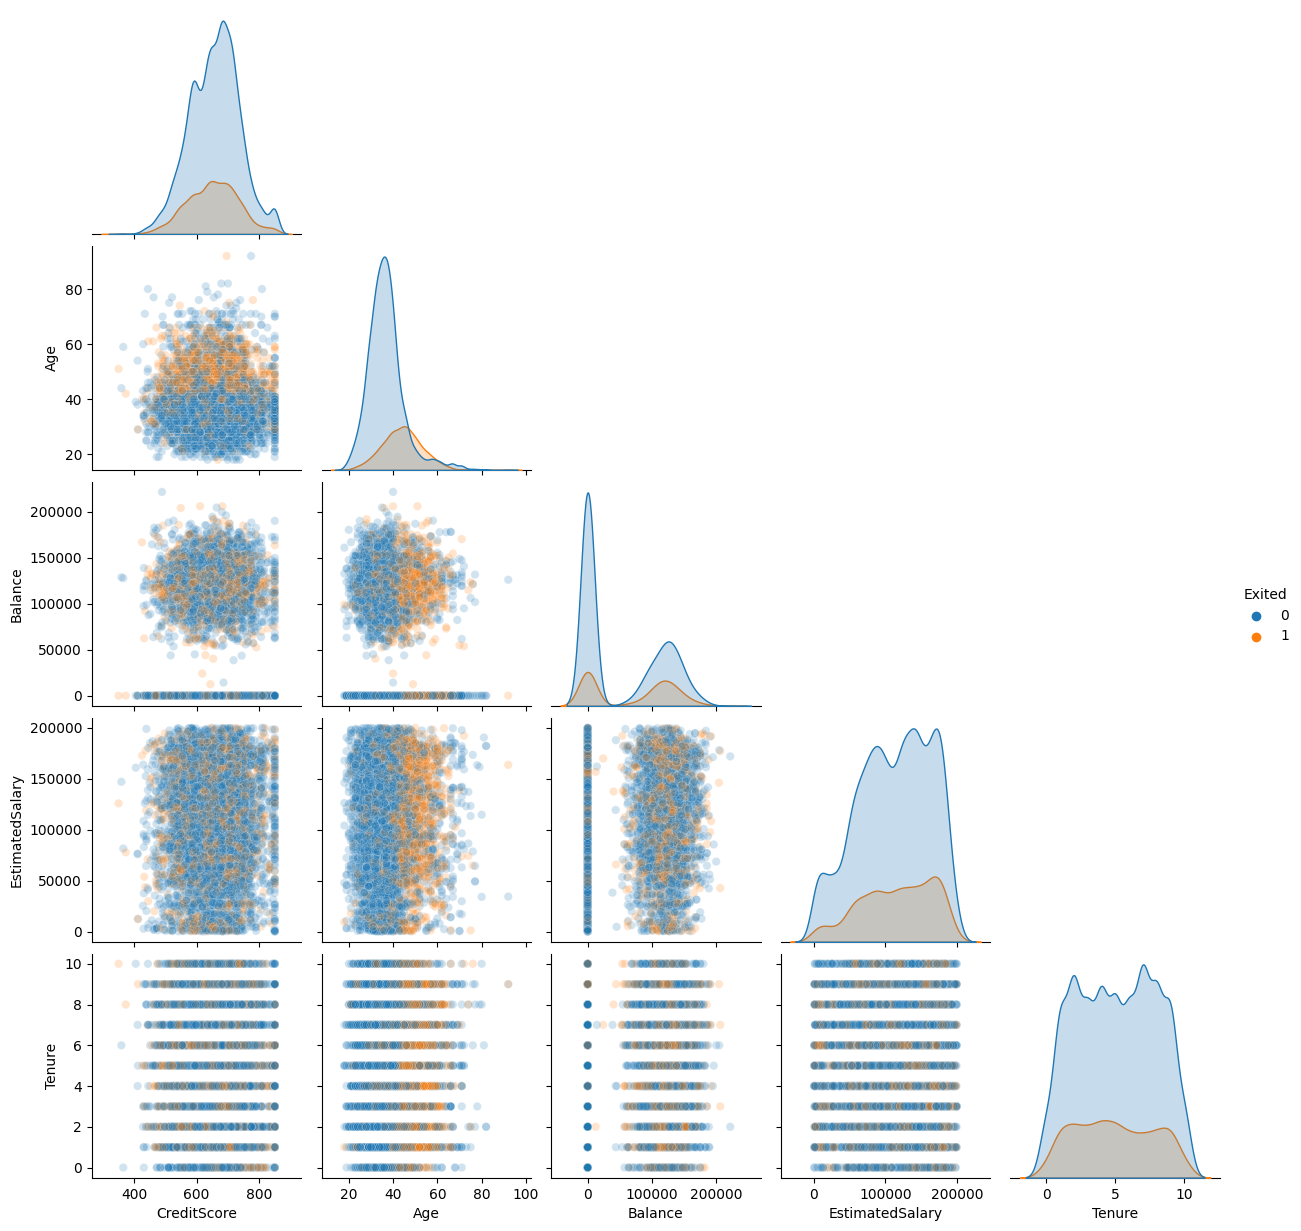

In [15]:
sns.pairplot(kind='scatter', data=train_df[['CreditScore','Age','Balance','EstimatedSalary','Exited', 'Tenure']].sample(frac=0.05), hue='Exited', plot_kws={'alpha':0.2},corner=True)

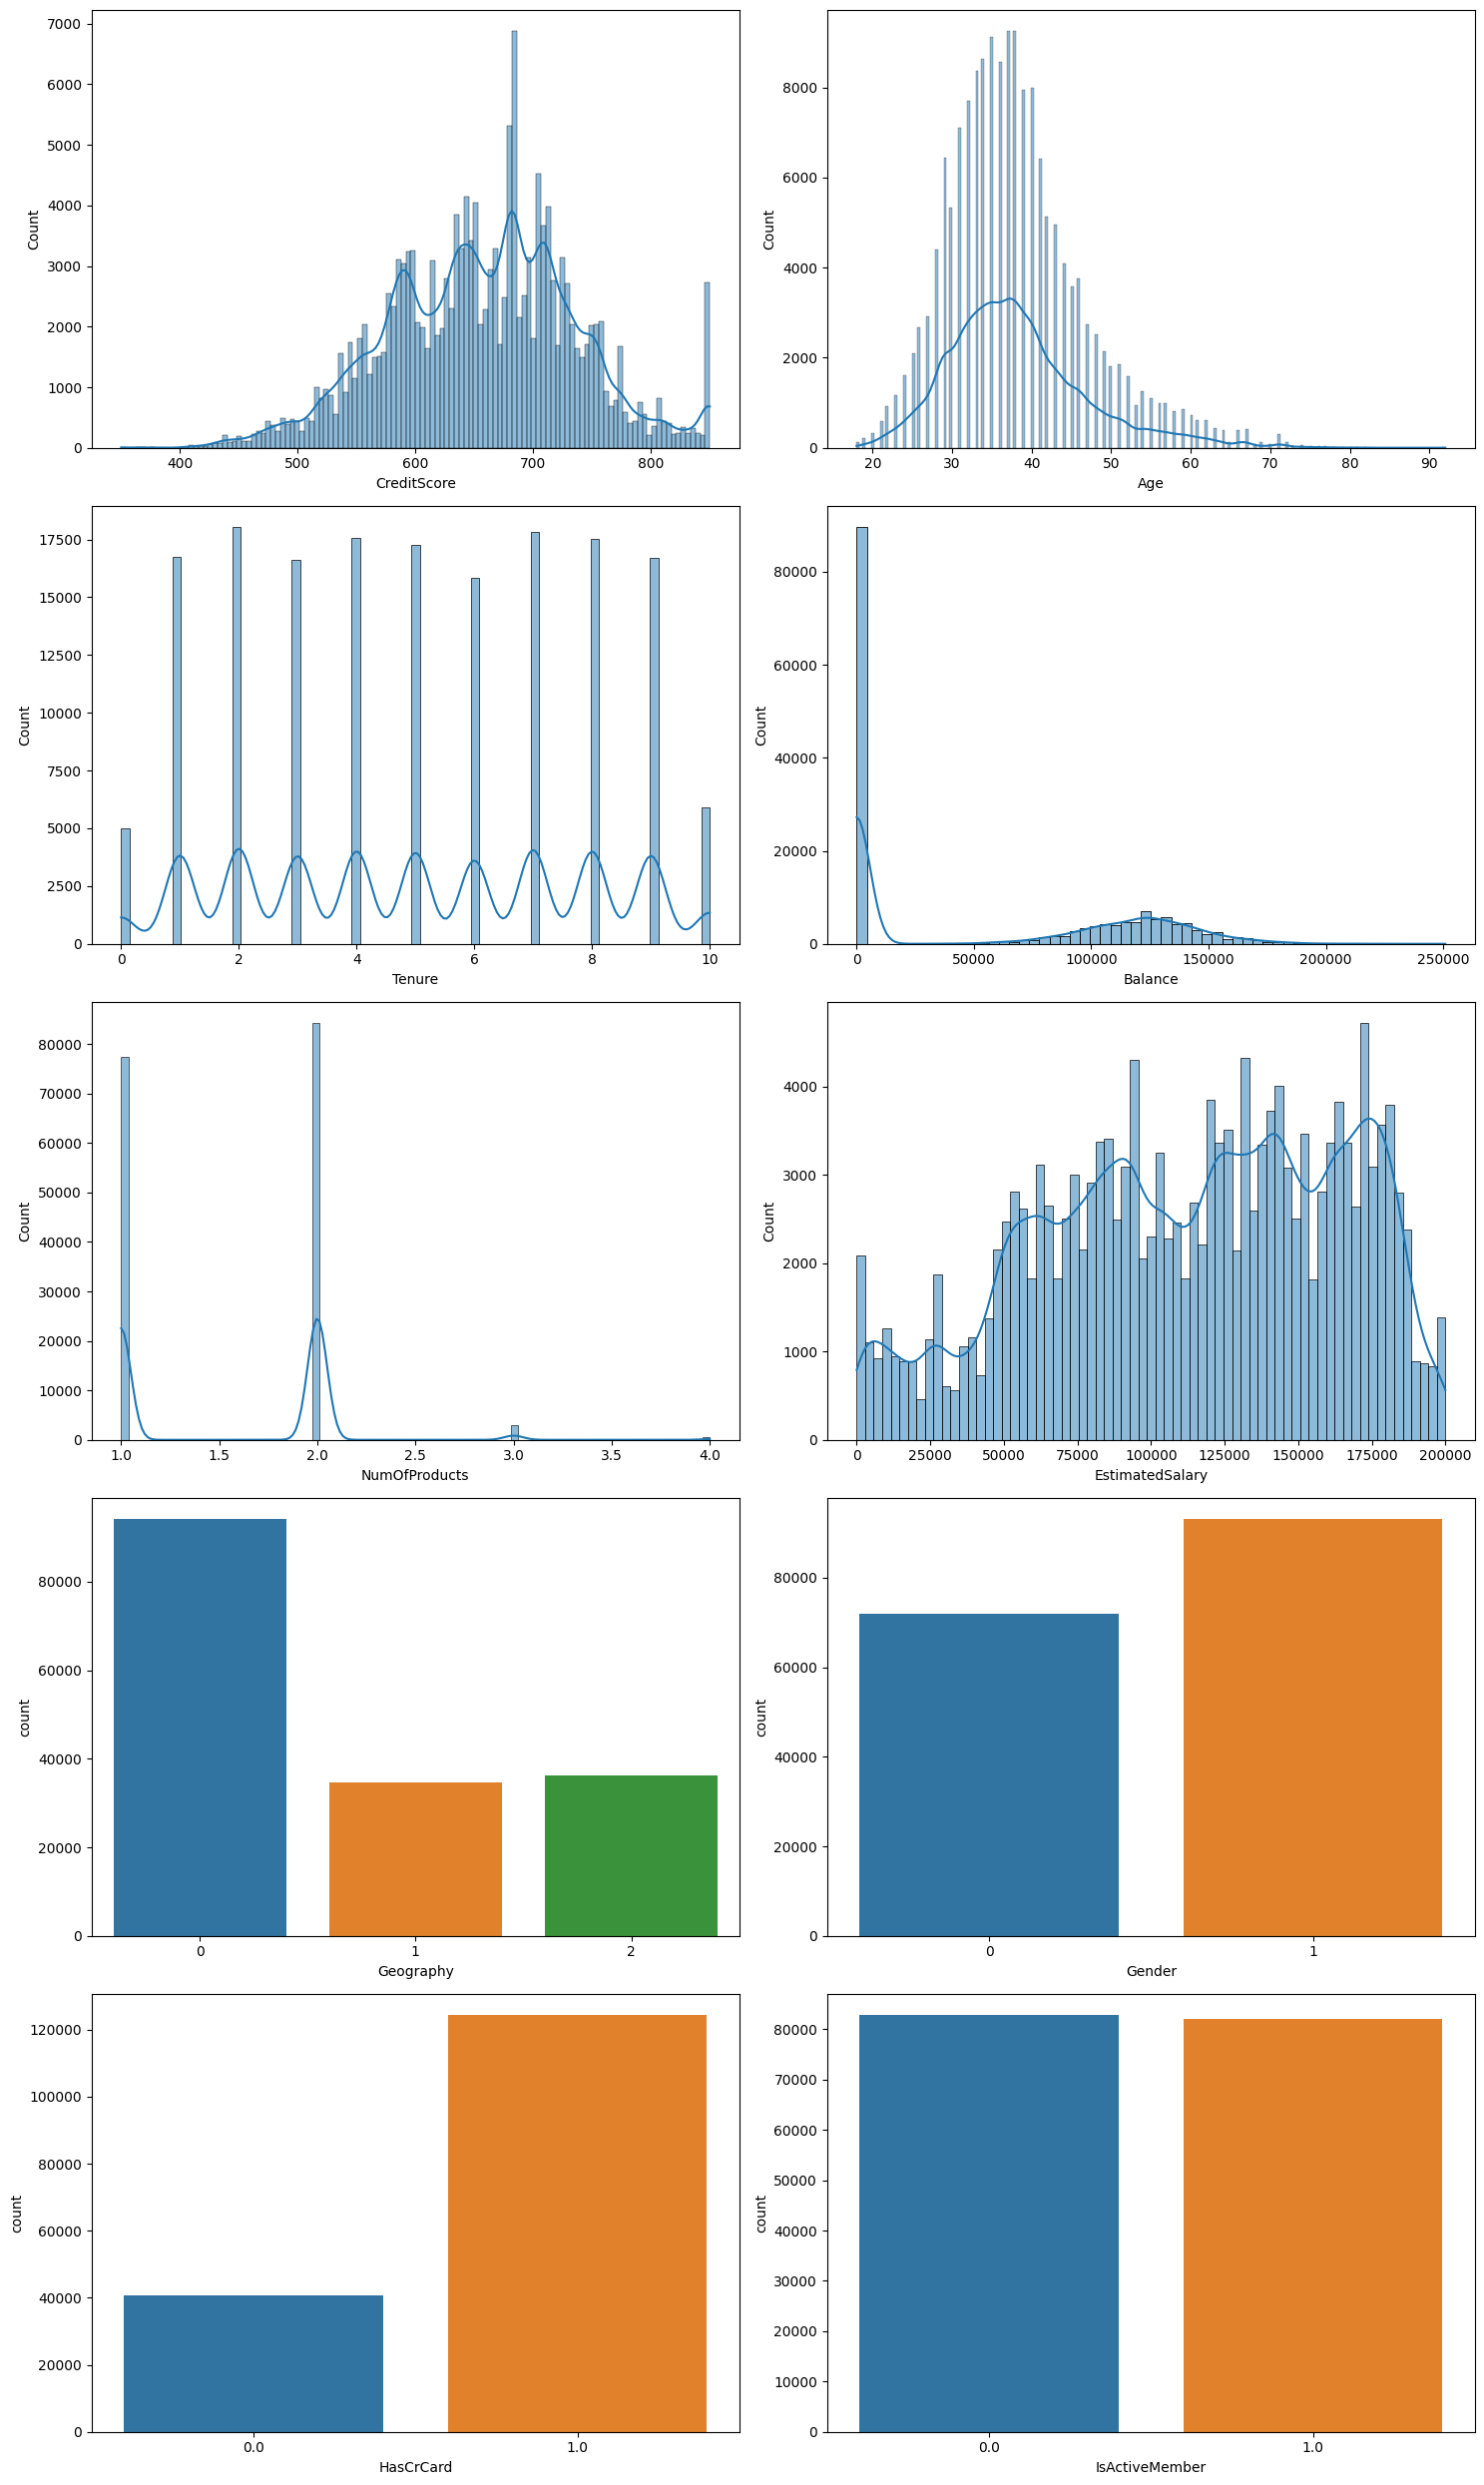

In [16]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

# Numerical Features
sns.histplot(data=train_df, x='CreditScore', kde=True, ax=axs[0, 0])
sns.histplot(data=train_df, x='Age', kde=True, ax=axs[0, 1])
sns.histplot(data=train_df, x='Tenure', kde=True, ax=axs[1, 0])
sns.histplot(data=train_df, x='Balance', kde=True, ax=axs[1, 1])
sns.histplot(data=train_df, x='NumOfProducts', kde=True, ax=axs[2, 0])
sns.histplot(data=train_df, x='EstimatedSalary', kde=True, ax=axs[2, 1])

# Categorical Features
sns.countplot(data=train_df, x='Geography', ax=axs[3, 0])
sns.countplot(data=train_df, x='Gender', ax=axs[3, 1])
sns.countplot(data=train_df, x='HasCrCard', ax=axs[4, 0])
sns.countplot(data=train_df, x='IsActiveMember', ax=axs[4, 1])

plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'Label distributution')

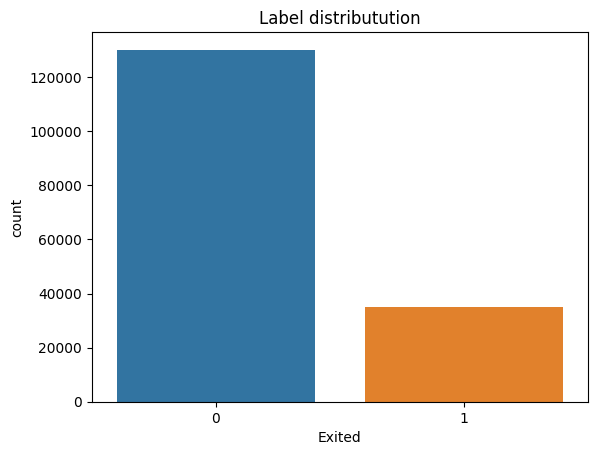

In [17]:
sns.countplot(data=train_df, x='Exited')
plt.title('Label distributution')

**Percentage of a group that exited**

In [18]:
print(train_df.groupby('Geography', as_index=False)['Exited'].mean())

   Geography    Exited
0          0  0.165282
1          1  0.378952
2          2  0.172176


In [19]:
print(train_df.groupby('HasCrCard', as_index=False)['Exited'].mean())

   HasCrCard    Exited
0        0.0  0.227429
1        1.0  0.206433


In [20]:
print(train_df.groupby('IsActiveMember', as_index=False)['Exited'].mean())

   IsActiveMember    Exited
0             0.0  0.297086
1             1.0  0.125345


In [21]:
print(train_df.groupby('NumOfProducts', as_index=False)['Exited'].mean())

   NumOfProducts    Exited
0              1  0.347119
1              2  0.060422
2              3  0.882516
3              4  0.875789


In [22]:
print(train_df.groupby('Gender', as_index=False)['Exited'].mean())

   Gender    Exited
0       0  0.279687
1       1  0.159055


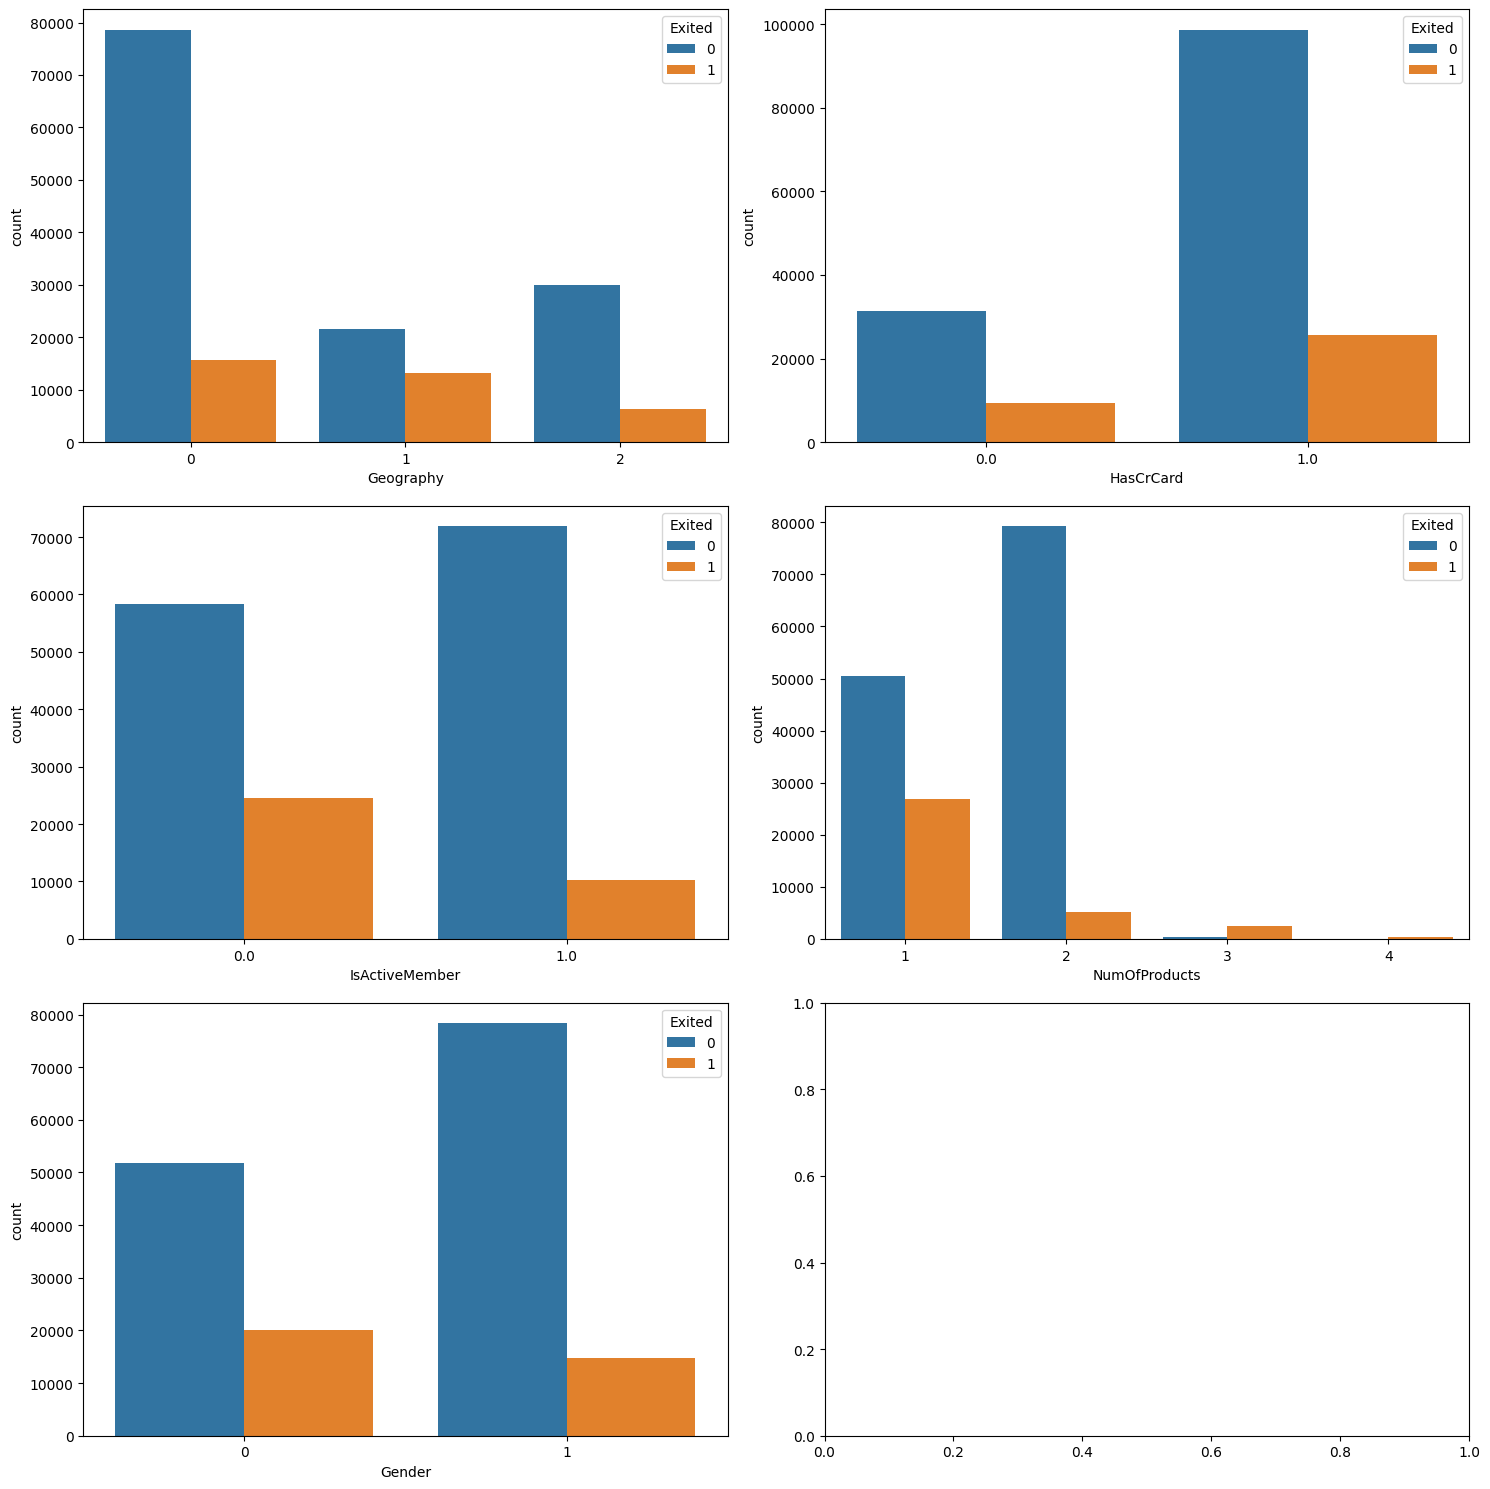

In [23]:
features = ['Geography', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Gender']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

counter = 0
for feature in features:

    row = counter // 2
    col = counter % 2

    sns.countplot(data=train_df, x=feature, hue='Exited', ax=axs[row, col])

    counter += 1

plt.tight_layout()

<Axes: xlabel='Tenure', ylabel='count'>

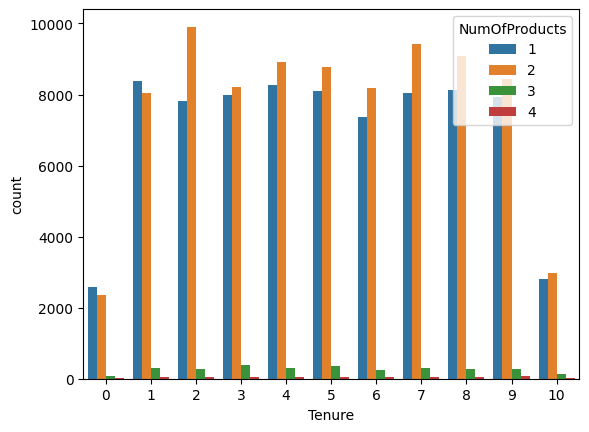

In [24]:
sns.countplot(data=train_df, x='Tenure', hue='NumOfProducts')

Only HasCreditCard feature is not important to determine who exited.

In [25]:
mean_df = train_df.groupby('Exited').mean().reset_index()
mean_df

,Exited,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,657.590710,0.625979,0.602046,36.560480,5.048796,51255.807752,1.615273,0.758894,0.552228,112084.293725
1,1,652.220469,0.732625,0.424272,43.958478,4.914378,71209.978085,1.327854,0.735546,0.294866,114402.496656


## Feature Engineering

There is a pattern in the Age of people who exited, they were between 45 and 60 years. \
I will therefore create three Age bins

There is a large group of peapole that have Balance equal to zero.\
I will create new column if they have positive Balance

These features were copied from other Kaggle competition notebooks\
Let`s see at the feature importance at the end of the notebook, if they were any good.

In [26]:
datasets = [train_df, test_df]

for dataset in datasets:
    
    # Creating Age bins
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0, 44, 59, np.inf], labels=[0,1,2]).astype('int64')
    
    # Creating HasBalance column
    dataset['HasBalance'] = dataset['Balance'].apply(lambda x: 0 if x == 0 else 1)
    
    # Other features copied from Kaggle
    dataset['IsActive_by_CreditCard'] = dataset['HasCrCard'] * dataset['IsActiveMember']
    dataset['Products_Per_Tenure'] =  dataset['Tenure'] / dataset['NumOfProducts']
    dataset['BalanceSalaryRatio'] = dataset['Balance'] / dataset['EstimatedSalary']
    dataset['TenureAgeRatio'] = dataset['Tenure'] / dataset['Age']
    dataset['TotalProducts'] = dataset['NumOfProducts'] + dataset['HasCrCard']

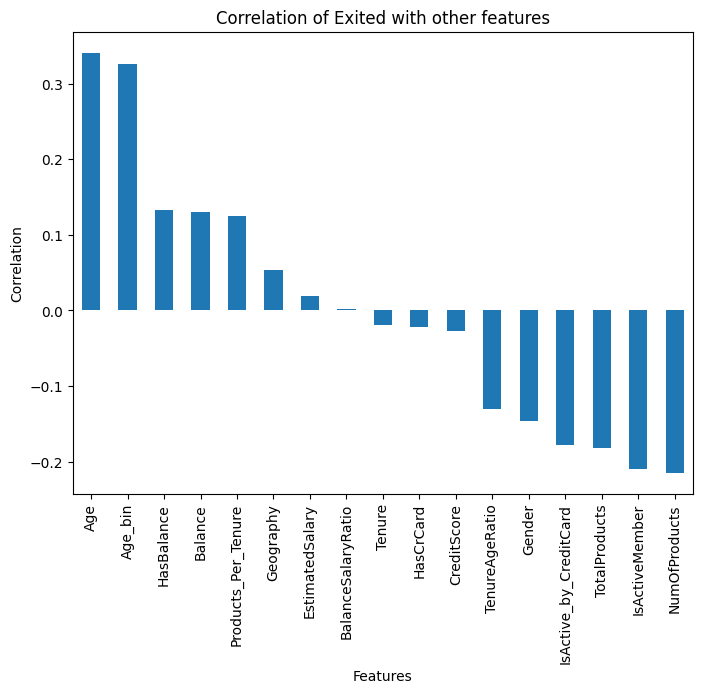

In [27]:

corr_matrix = train_df.corr()
hascrCard_corr = corr_matrix["Exited"]
hascrCard_corr = hascrCard_corr.sort_values(ascending=False).drop('Exited')

plt.figure(figsize=(8,6))
hascrCard_corr.plot(kind='bar')
plt.title('Correlation of Exited with other features')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

## Encoding the data

Only column 'Geography' needs to be one hot encoded. Other columns are already label encoded.

In [28]:
train_df = pd.get_dummies(train_df, columns=['Geography'], prefix='Geo', drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Geography'], prefix='Geo', drop_first=True)

In [29]:
test_df.shape

(110023, 18)

## Scaling the data

LightGBM model does not require scaling the data

## Splitting the data

In [30]:
X = train_df.drop('Exited',axis=1)

In [31]:
y=train_df['Exited']

In [32]:
print(X.shape)
print(y.shape)

(165034, 18)
(165034,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(132027, 18)
(33007, 18)
(132027,)
(33007,)


## Creating ML models

### 1. LightGBM

In [35]:
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train,y_train)

LGBMClassifier(random_state=42)

In [36]:
def evaluate_model(model):
    preds = model.predict(X_train)
    predicted_proba = model.predict_proba(X_train)
    print(classification_report(y_train, preds))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['No', 'Yes'])
    roc_auc = roc_auc_score(y_train, predicted_proba[:, 1])
    print('ROC-AUC Score is: ', round(roc_auc, 3))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92    104061
           1       0.75      0.57      0.65     27966

    accuracy                           0.87    132027
   macro avg       0.82      0.76      0.78    132027
weighted avg       0.86      0.87      0.86    132027

ROC-AUC Score is:  0.898


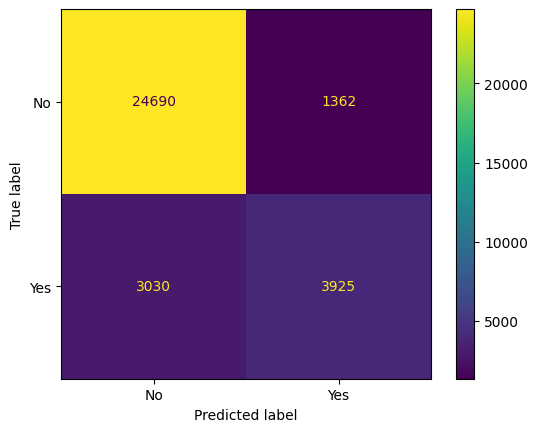

In [37]:
evaluate_model(lgbm_model)

### 2. XGBoost

In [38]:
xgb_model = xgb.XGBRFClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(X_train,y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=42, reg_alpha=None, ...)

              precision    recall  f1-score   support

           0       0.89      0.94      0.91    104061
           1       0.71      0.58      0.64     27966

    accuracy                           0.86    132027
   macro avg       0.80      0.76      0.78    132027
weighted avg       0.86      0.86      0.86    132027

ROC-AUC Score is:  0.885


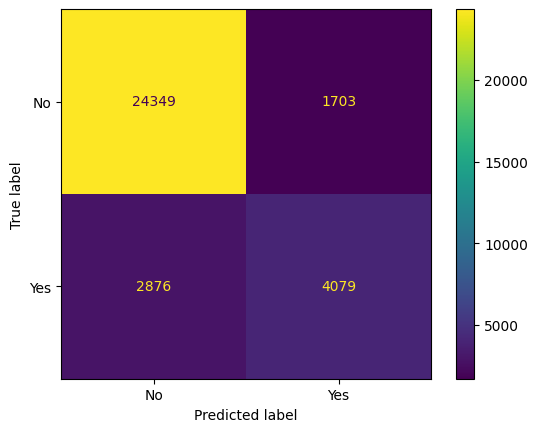

In [39]:
evaluate_model(xgb_model)

### 3. Adaptive boosted

In [40]:
adaboost_model = AdaBoostClassifier(random_state=42)
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91    104061
           1       0.74      0.53      0.61     27966

    accuracy                           0.86    132027
   macro avg       0.81      0.74      0.76    132027
weighted avg       0.85      0.86      0.85    132027

ROC-AUC Score is:  0.88


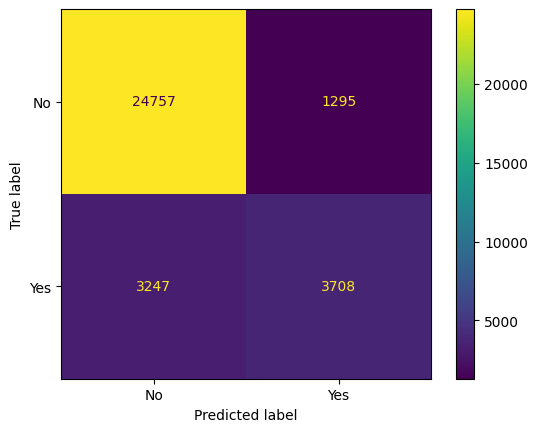

In [41]:
evaluate_model(adaboost_model)

### 4. CatBoost

In [42]:
catboost_model = CatBoostClassifier(random_state=42, verbose=False)
catboost_model.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93    104061
           1       0.79      0.59      0.67     27966

    accuracy                           0.88    132027
   macro avg       0.84      0.77      0.80    132027
weighted avg       0.87      0.88      0.87    132027

ROC-AUC Score is:  0.91


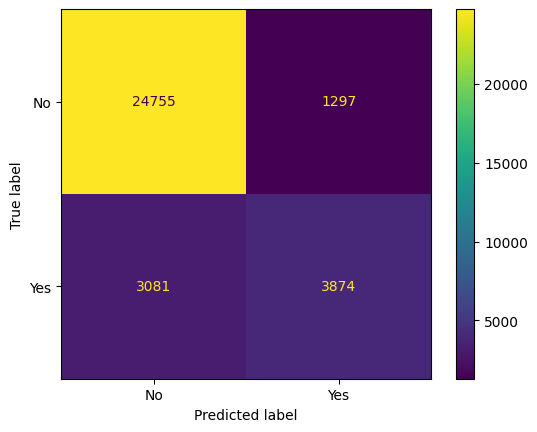

In [43]:
evaluate_model(catboost_model)

In [44]:
def draw_ROC_curve(models):
    plt.figure(figsize=(7,7),dpi=100)
    for model_key, model_value in models.items():
        # Calculate the probabilities on the test set
        y_probs = model_key.predict_proba(X_test)[:, 1]

        # Compute the ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_probs,)

        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f'{model_value}: AUC = {auc(fpr, tpr):.2f}')

    # Plot Catboost
    catboost_pool = Pool(X_test, y_test)
    (fpr, tpr, thresholds) = get_roc_curve(catboost_model, catboost_pool)
    plt.plot(fpr, tpr, label=f'CatBoost (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label='Chance level')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for Multiple models')
    plt.legend(loc="lower right")
    plt.show()


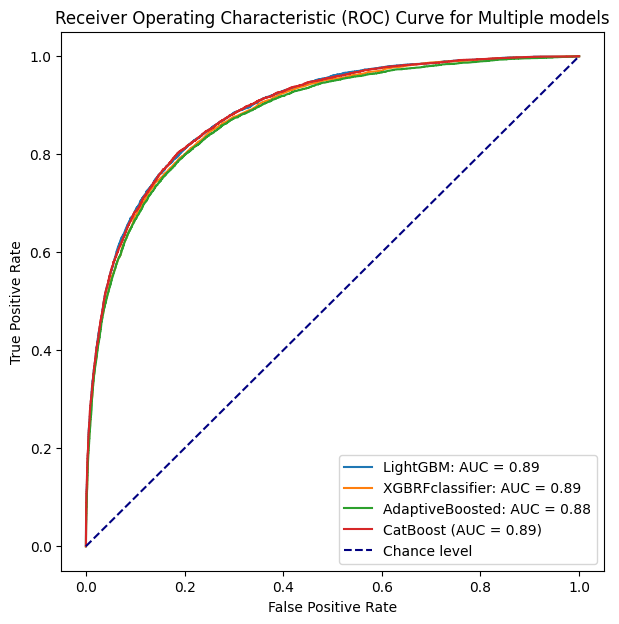

In [45]:
models = {lgbm_model:"LightGBM", xgb_model:"XGBRFclassifier", adaboost_model:"AdaptiveBoosted"}
draw_ROC_curve(models=models)

Catboost is performing the best, and Adaptiveboosted tree is performing the worst. \
I will further deal only with LightGBM model, as it was the fastest to compute.

## Hyperparameter tuning for LightGBM model

In [46]:
lgbm_param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': np.arange(2, 32),
    'max_depth': np.arange(1, 10),
    'learning_rate': np.logspace(-3, 0, 10),
    'n_estimators': np.arange(10, 200, 10),
    'class_weight': [None, 'balanced']
    }   

In [47]:
lgbm_random_search = RandomizedSearchCV(
    lgbm_model,
    param_distributions=lgbm_param_grid,
    n_iter=20,
    cv=4,
    verbose= 0,
    n_jobs=-1,
    scoring='roc_auc'
)

In [48]:
lgbm_random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=4, estimator=LGBMClassifier(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'class_weight': [None, 'balanced'],
                                        'learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                        'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190]),
                                        'num_leaves': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])},
                   scoring='roc_auc')

In [49]:
lgbm_random_search.best_params_

{'num_leaves': 15,
 'n_estimators': 100,
 'max_depth': 9,
 'learning_rate': 0.1,
 'class_weight': None,
 'boosting_type': 'gbdt'}

## Retrain model on all data

In [50]:
final_model = LGBMClassifier(**lgbm_random_search.best_params_)
final_model.fit(X,y)

LGBMClassifier(max_depth=9, num_leaves=15)

In [51]:
feature_importances = final_model.feature_importances_
feature_names = test_df.columns

# Create a DataFrame with the feature names and importances
feature_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
feature_df = feature_df.sort_values('importance', ascending=False)
feature_df

,feature,importance
2,Age,278
5,NumOfProducts,213
4,Balance,205
0,CreditScore,150
8,EstimatedSalary,111
16,Geo_1,80
13,BalanceSalaryRatio,74
7,IsActiveMember,71
14,TenureAgeRatio,65
1,Gender,59


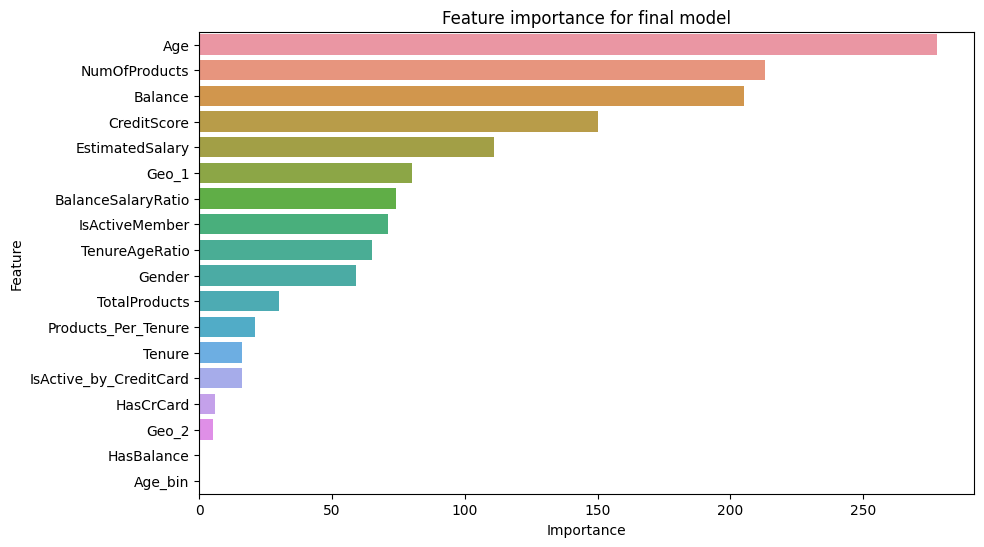

In [52]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_df.head(20))
plt.title('Feature importance for final model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [53]:
final_pred = final_model.predict_proba(test_df)
final_pred

array([[0.97149487, 0.02850513],
       [0.19289617, 0.80710383],
       [0.96902173, 0.03097827],
       ...,
       [0.98332893, 0.01667107],
       [0.84556703, 0.15443297],
       [0.81059016, 0.18940984]])

In [54]:
final_pred_df = pd.DataFrame(final_pred[:,1])
submission = pd.concat([sample_sub['id'], final_pred_df], axis=1)
submission.columns = ['id', 'Exited']
submission.head()

,id,Exited
0,165034,0.028505
1,165035,0.807104
2,165036,0.030978
3,165037,0.237678
4,165038,0.370276


In [55]:
submission.to_csv('/kaggle/working/submission.csv', index=False)